# Symforce Tutorial

### Notebook ini adalah tutorial untuk menggunakan Symforce. Tutorial ini akan membahas tentang:
- Instalasi Symforce menggunakan pip via bash command
- contoh sederhana pemodelan dan penyelesaian masalah pengoptimalan dengan SymForce. Dalam contoh ini robot bergerak melalui bidang 2D dan tujuannya adalah untuk memperkirakan posenya pada beberapa langkah waktu dengan pengukuran kebisingan.


<!-- ![Robot Heading Ilustration](https://symforce.org/docs/static/images/robot_2d_localization/problem_setup.png) -->
<img src="https://symforce.org/docs/static/images/robot_2d_localization/problem_setup.png" alt="Robot Heading Ilustration" width="400"/>

#### Instalasi Symforce menggunakan pip via bash command
*Note : tested menggunakan Github Codespace dengan Ubuntu 20.04*


In [26]:
%%bash
pip install symforce

In [7]:
import symforce.symbolic as sym
import numpy as np

In [3]:
pose =sym.Pose2(
    t=sym.V2.symbolic('t'),
    R=sym.Rot2.symbolic('R')
)
landmark= sym.V2.symbolic('L')

In [4]:
landmark_body=pose.inverse() * landmark     

In [5]:
landmark_body.jacobian(pose)

[-L0*R_im + L1*R_re + t0*R_im - t1*R_re, -R_re, -R_im]
[-L0*R_re - L1*R_im + t0*R_re + t1*R_im, R_im, -R_re]

In [6]:
sym.atan2(landmark_body[0], landmark_body[1])

atan2(L0*R_re + L1*R_im - (t0*R_re + t1*R_im), -L0*R_im + L1*R_re - (-t0*R_im + t1*R_re))

In [7]:
sym.V3.symbolic('x').norm(epsilon=sym.epsilon())

sqrt(x0**2 + x1**2 + x2**2)

In [1]:
import symforce
try :
    symforce.set_epsilon_to_symbol()
except AlreadyUsedEpsilon:
    pass

Keterangan

In [5]:
from symforce.values import Values

In [3]:
num_poses=3
num_landmarks=3

In [8]:
initial_values=Values(
    poses=[sym.Pose2.identity()] * num_poses,
    landmarks=[sym.V2(-2, 2), sym.V2(1, -3), sym.V2(5, 2)],
    distances=[1.7, 1.4],
    angles=np.deg2rad([[145, 335, 55], [185, 310, 70], [215, 310, 70]]).tolist(),
    epsilon=sym.numeric_epsilon,
)

In [9]:
def bearing_residual(
    pose: sym.Pose2, landmark: sym.V2, angle: sym.Scalar, epsilon: sym.Scalar
) -> sym.V1:
    t_body = pose.inverse() * landmark
    predicted_angle = sym.atan2(t_body[1], t_body[0], epsilon=epsilon)
    return sym.V1(sym.wrap_angle(predicted_angle - angle))

In [10]:
def odometry_residual(
    pose_a: sym.Pose2, pose_b: sym.Pose2, dist: sym.Scalar, epsilon: sym.Scalar
) -> sym.V1:
    return sym.V1((pose_b.t - pose_a.t).norm(epsilon=epsilon) - dist)

In [11]:
from symforce.opt.factor import Factor

factors = []

# Bearing factors
for i in range(num_poses):
    for j in range(num_landmarks):
        factors.append(Factor(
            residual=bearing_residual,
            keys=[f"poses[{i}]", f"landmarks[{j}]", f"angles[{i}][{j}]", "epsilon"],
        ))

# Odometry factors
for i in range(num_poses - 1):
    factors.append(Factor(
        residual=odometry_residual,
        keys=[f"poses[{i}]", f"poses[{i + 1}]", f"distances[{i}]", "epsilon"],
    ))
import warnings
warnings.filterwarnings("ignore")

In [12]:
from symforce.opt.optimizer import Optimizer

optimizer = Optimizer(
    factors=factors,
    optimized_keys=[f"poses[{i}]" for i in range(num_poses)],
    # So that we save more information about each iteration, to visualize later:
    debug_stats=True,
)

In [13]:
result = optimizer.optimize(initial_values)

[2022-12-01 07:26:56.623] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 5.143/2.872/2.203, rel reduction: 0.57166
[2022-12-01 07:26:56.623] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 2.203/0.087/0.074, rel reduction: 0.96655
[2022-12-01 07:26:56.624] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 0.074/0.006/0.006, rel reduction: 0.91401
[2022-12-01 07:26:56.624] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 0.006/0.001/0.001, rel reduction: 0.90323
[2022-12-01 07:26:56.625] [info] LM<sym::Optimize> [iter    4] lambda: 3.906e-03, error prev/linear/new: 0.001/0.000/0.000, rel reduction: 0.60930
[2022-12-01 07:26:56.626] [info] LM<sym::Optimize> [iter    5] lambda: 9.766e-04, error prev/linear/new: 0.000/0.000/0.000, rel reduction: 0.08144
[2022-12-01 07:26:56.626] [info] LM<sym::Optimize> [iter    6] lambda: 2.441e-04, error prev/linear/new: 0.000/0.000/0

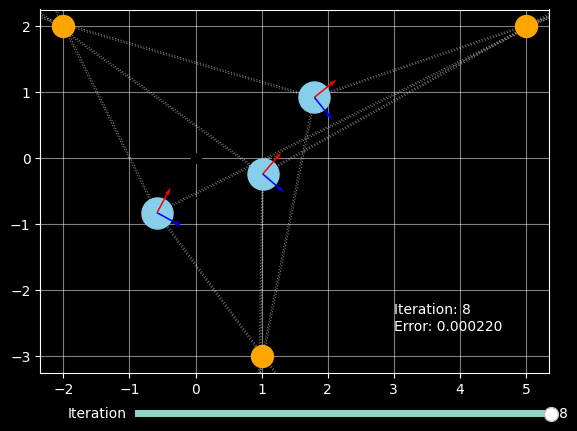

In [14]:
from symforce.examples.robot_2d_localization.plotting import plot_solution
plot_solution(optimizer, result)

### Generate C++ Code
Untuk setiap faktor, SymForce mengintrospeksi bentuk fungsi simbolik, melewati input simbolik untuk membuat ekspresi output, secara otomatis menghitung jacobian dari ekspresi output tersebut dengan variabel yang dioptimalkan, dan menghasilkan kode runtime cepat untuk variabel tersebut.
Class Codegen adalah alat utama untuk menghasilkan kode runtime dari ekspresi simbolik. Dalam hal ini, kami meneruskan fungsi residual_bearing dan mengonfigurasinya untuk menghasilkan kode C++:

In [15]:
from symforce.codegen import Codegen, CppConfig

codegen = Codegen.function(bearing_residual, config=CppConfig())

In [16]:
codegen_linearization = codegen.with_linearization(
    which_args=["pose"]
)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
metadata = codegen_linearization.generate_function()
# with open('coba.cpp', 'w') as f:
#     f.write(metadata.generated_files[0])
#     f.close()
# with open(metadata.generated_files[0]).read() as f:
#     lines = f.readlines()
#     lines = [l for l in lines if "ROW" in l]
#     with open("out.txt", "w") as f1:
#         f1.writelines(lines)
# print(type(metadata.generated_files[0]))
code=open(metadata.generated_files[0]).read()
with open('coba.cpp', 'w') as f:
    f.write(code)
# print(open(metadata.generated_files[0]).read())

In [25]:
%%bash
wget https://raw.githubusercontent.com/symforce-org/symforce/main/gen/cpp/sym/pose2.h -P ./sym

--2022-12-01 07:49:41--  https://raw.githubusercontent.com/symforce-org/symforce/main/gen/cpp/sym/pose2.h
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8015 (7.8K) [text/plain]
Saving to: ‘./sym/pose2.h’

     0K .......                                               100% 21.2M=0s

2022-12-01 07:49:42 (21.2 MB/s) - ‘./sym/pose2.h’ saved [8015/8015]

